In [105]:
#import necessary libraries 
import seaborn as sns
#import geopandas as gpd
#import contextily as ctx
#import folium 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings ("ignore")

In [106]:
#load and preview dataset first 50 observations
illegal_df = pd.read_csv("Illegal activities.csv", low_memory= False)
illegal_df.head(12)

,Waypoint Date,Waypoint Time,X,Y,Observation Category 0,Observation Category 1,Observation Category 2,Action Taken Camp,Action Taken Items,Action Taken People,...,Count,Reason For,Sex,Status,Timber Tree Species,Trap Size,Type of Cutting Tool,Type of Human Sign,Type of Trap,Type of Weapon
0,28-Nov-19,6:52:34 AM,601081.5188,9639489.998,Human Activity,People - indirect sign,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Footprint,NaN,NaN
1,06-Apr-21,2:06:49 PM,590817.0001,9618274.553,Human Activity,People,NaN,NaN,NaN,Arrested,...,1,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06-Apr-21,2:06:49 PM,590817.0001,9618274.553,Cutting Tools,NaN,NaN,NaN,Collected,NaN,...,2,NaN,NaN,NaN,NaN,NaN,Handsaw,NaN,NaN,NaN
3,06-Apr-21,2:06:49 PM,590817.0001,9618274.553,Human Activity,Timber,Building Poles,NaN,Collected,NaN,...,2,NaN,NaN,NaN,Hard Wood,NaN,NaN,NaN,NaN,NaN
4,10-Jul-21,11:09:13 AM,610882.8643,9636109.150,Human Activity,Timber,Cut branches,NaN,Observed Only,NaN,...,1,NaN,NaN,NaN,Hard Wood,NaN,NaN,NaN,NaN,NaN
5,12-Feb-21,4:31:27 PM,595069.2919,9613245.000,Traps and Snares,NaN,NaN,NaN,Collected,NaN,...,1,NaN,NaN,NaN,NaN,Small,NaN,NaN,Snare,NaN
6,09-Aug-21,1:15:02 PM,593225.8838,9639809.145,Traps and Snares,NaN,NaN,NaN,Collected,NaN,...,1,NaN,NaN,NaN,NaN,Small,NaN,NaN,Snare,NaN
7,27-Jun-19,10:29:16 AM,607434.9180,9637604.844,Human Activity,Timber,Building Poles,NaN,Observed Only,NaN,...,1,NaN,NaN,NaN,Hard Wood,NaN,NaN,NaN,NaN,NaN
8,16-Jun-21,1:19:32 PM,596582.0738,9629489.653,Human Activity,People - indirect sign,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,Litter,NaN,NaN
9,09-Apr-21,12:38:26 PM,590886.5009,9620416.127,Human Activity,Timber,Cut Stems,NaN,Observed Only,NaN,...,1,NaN,NaN,NaN,Hard Wood,NaN,NaN,NaN,NaN,NaN


In [107]:
# a preview of the columns in the dataset
for cols in illegal_df.columns:
    print (cols)

Waypoint Date
Waypoint Time
X
Y
Observation Category 0
Observation Category 1
Observation Category 2
Action Taken Camp
Action Taken Items
Action Taken People
Age of Sign
Arrested For
Comment
Home Town
Is Active
Location Of Fire
Name or Names
National ID Number
Count
Reason For
Sex
Status
Timber Tree Species
Trap Size
Type of Cutting Tool
Type of Human Sign
Type of Trap
Type of Weapon


In [108]:
#descriptive summary or information of the dataframe
illegal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18762 entries, 0 to 18761
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Waypoint Date           18762 non-null  object 
 1   Waypoint Time           18762 non-null  object 
 2   X                       18762 non-null  float64
 3   Y                       18762 non-null  float64
 4   Observation Category 0  18762 non-null  object 
 5   Observation Category 1  8738 non-null   object 
 6   Observation Category 2  6904 non-null   object 
 7   Action Taken Camp       61 non-null     object 
 8   Action Taken Items      16769 non-null  object 
 9   Action Taken People     297 non-null    object 
 10  Age of Sign             7812 non-null   object 
 11  Arrested For            282 non-null    object 
 12  Comment                 7895 non-null   object 
 13  Home Town               208 non-null    object 
 14  Is Active               8779 non-null 

In [109]:
#drop features with zero entries, not significant 
#feature engineer the columns 
feature = illegal_df[['Name or Names', 'National ID Number','Sex',"Reason For","Age of Sign","Comment"]]
illegal_df = illegal_df.drop(columns= feature, axis =1)

In [110]:
# Dropping rows where "Observation Category 1" is 'People - indirect sign'
illegal_df = illegal_df[illegal_df["Observation Category 1"] != 'People - indirect sign']
illegal_df = illegal_df[illegal_df["Observation Category 1"] != 'Infrastructure & Roads']

illegal_df["Observation Category 1"].unique()

array(['People', nan, 'Timber', 'Camp', 'Fire'], dtype=object)

In [111]:
# Function to categorize entries
def categorize_entries(row):
    """
    This function categorizes observtion category 0 into poaching and logging 
    using columns Arrested For and observation category 1
    """
    if row['Observation Category 0'] == 'Traps and Snares':
        return 'Poaching'
    elif row['Observation Category 0'] == 'Cutting Tools':
        return 'Logging'
    elif row['Observation Category 0'] == 'Weapons':
        return 'Poaching'
    elif row['Observation Category 0'] == 'Human Activity':
        if row['Observation Category 1'] in ['Timber', 'Camp', 'Fire']:
            return 'Logging'
        elif row['Observation Category 1'] == 'People':
            if row['Arrested For'] == 'Hunting':
                return 'Poaching'
            else:
                return 'Logging'
    return row['Observation Category 0'] 

# Apply the function to the dataframe
illegal_df['Observation Category 0'] = illegal_df.apply(categorize_entries, axis=1)

In [112]:
#check value counts for observation category 0
illegal_df['Observation Category 0'].value_counts()

Poaching    9860
Logging     7455
Name: Observation Category 0, dtype: int64

In [113]:
# create a function that loops and reads all unique values in the dataframe
#reason: to read missing value and analyze how to replace with appropriate special character
def unique_values(data): 
    # create a dictionary of columns and unique values in it
    
    #create an empty list
    distinct_values = {}
    
    #loop over each column in the list to create dictionary with unique values 
    for cols in data.columns:
        distinct_values[cols] = data[cols].unique()
        
        #print all each column with its respective unique value
    for keys,values in distinct_values.items():
            print (keys,":-", values)
            
# print the unique values for each column
unique_values(illegal_df)

Waypoint Date :- ['06-Apr-21' '10-Jul-21' '12-Feb-21' ... '25-Nov-21' '15-Oct-19'
 '13-Jul-23']
Waypoint Time :- ['2:06:49 PM' '11:09:13 AM' '4:31:27 PM' ... '10:21:54 AM' '10:25:14 AM'
 '12:27:12 PM']
X :- [590817.0001 610882.8643 595069.2919 ... 592281.443  592450.3033
 602504.988 ]
Y :- [9618274.553 9636109.15  9613245.    ... 9626030.588 9638909.037
 9635392.48 ]
Observation Category 0 :- ['Logging' 'Poaching']
Observation Category 1 :- ['People' nan 'Timber' 'Camp' 'Fire']
Observation Category 2 :- [nan 'Building Poles' 'Cut branches' 'Cut Stems' 'Charcoal' 'Firewood'
 'Logs' 'Fitoes' 'Planks' 'Carving']
Action Taken Camp :- [nan 'Observed Only' 'Destroyed']
Action Taken Items :- [nan 'Collected' 'Observed Only' 'Destroyed' 'Confiscated']
Action Taken People :- ['Arrested' nan 'Unsuccessful Pursuit' 'Verbal Warning' 'Written Warning'
 'Observed Only']
Arrested For :- ['Logging' nan 'Illegal Entry Into Forest' 'Fire Wood Collection'
 'Hunting' 'Wood Carving' 'Charcoal Burning']
Hom

In [114]:
#filling missing values and replacing (with) appropriate values 

# create a column: value dictionary for fill

appropriate_characters = {
    "Type of Weapon": "No weapon",
    "Type of Trap": "No trap",
    "Type of Human Sign": "Absence of Human sign",
    "Type of Cutting Tool": "No Cutting Tool",
    "Trap Size": "No Trap",
    "Timber Tree Species": "Other",
    "Status": "No Camp",
    "Location Of Fire": "Other",
    "Is Active": "Not applicable",
    "Action Taken People": "No arrest",
    "Action Taken Items": "No Item",
    "Action Taken Camp": "No Camp",
    "Observation Category 2": "Not applicable",
    "Home Town":"Other",
    "Arrested For":"No Arrest"
}

# loop over each column to fill missing values 
"""
This loops checks for all missing values and replaces the missing values
with appropriate characters that provide insights to the data
"""
for cols, appropriate_characters in appropriate_characters.items():
    illegal_df[cols] = illegal_df[cols].fillna(appropriate_characters)

# preview new dataset using the unique_values() function
unique_values(illegal_df)


Waypoint Date :- ['06-Apr-21' '10-Jul-21' '12-Feb-21' ... '25-Nov-21' '15-Oct-19'
 '13-Jul-23']
Waypoint Time :- ['2:06:49 PM' '11:09:13 AM' '4:31:27 PM' ... '10:21:54 AM' '10:25:14 AM'
 '12:27:12 PM']
X :- [590817.0001 610882.8643 595069.2919 ... 592281.443  592450.3033
 602504.988 ]
Y :- [9618274.553 9636109.15  9613245.    ... 9626030.588 9638909.037
 9635392.48 ]
Observation Category 0 :- ['Logging' 'Poaching']
Observation Category 1 :- ['People' nan 'Timber' 'Camp' 'Fire']
Observation Category 2 :- ['Not applicable' 'Building Poles' 'Cut branches' 'Cut Stems' 'Charcoal'
 'Firewood' 'Logs' 'Fitoes' 'Planks' 'Carving']
Action Taken Camp :- ['No Camp' 'Observed Only' 'Destroyed']
Action Taken Items :- ['No Item' 'Collected' 'Observed Only' 'Destroyed' 'Confiscated']
Action Taken People :- ['Arrested' 'No arrest' 'Unsuccessful Pursuit' 'Verbal Warning'
 'Written Warning' 'Observed Only']
Arrested For :- ['Logging' 'No Arrest' 'Illegal Entry Into Forest' 'Fire Wood Collection'
 'Huntin

In [115]:
# Define mapping for filling NaN values in Observation Category 1
mapping = {
    'Logging': 'Timber',
    'Poaching': 'People'
}

# Fill NaN values in Observation Category 1 based on Observation Category 0
illegal_df['Observation Category 1'] = illegal_df['Observation Category 1'].fillna(illegal_df['Observation Category 0'].map(mapping))

In [116]:
#check value counts for Observation Category 1
illegal_df['Observation Category 1'].value_counts()

People    10153
Timber     7090
Camp         63
Fire          9
Name: Observation Category 1, dtype: int64

In [117]:
#change columns names of X,Y to Eastings and Northings 
illegal_df.rename(columns={"X": "Eastings/Longitude","Y":"Northings/Latitude"}, inplace= True)
illegal_df.rename(columns={"Observation Category 0": "Illegal Activity"}, inplace= True)
#change datatype of Eastings and Northings to strings from float, they are unique IDs
illegal_df["Eastings/Longitude"] = illegal_df["Eastings/Longitude"]#.astype(str)
illegal_df["Northings/Latitude"] = illegal_df["Northings/Latitude"]#.astype(str)


In [118]:
#preview Dataframe
illegal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17315 entries, 1 to 18761
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Waypoint Date           17315 non-null  object 
 1   Waypoint Time           17315 non-null  object 
 2   Eastings/Longitude      17315 non-null  float64
 3   Northings/Latitude      17315 non-null  float64
 4   Illegal Activity        17315 non-null  object 
 5   Observation Category 1  17315 non-null  object 
 6   Observation Category 2  17315 non-null  object 
 7   Action Taken Camp       17315 non-null  object 
 8   Action Taken Items      17315 non-null  object 
 9   Action Taken People     17315 non-null  object 
 10  Arrested For            17315 non-null  object 
 11  Home Town               17315 non-null  object 
 12  Is Active               17315 non-null  object 
 13  Location Of Fire        17315 non-null  object 
 14  Count                   17315 non-null

In [119]:
#reset index to deal with difference in observations and rows
illegal_df.reset_index(drop=True, inplace=True)


In [120]:
#recheck missing values
illegal_df.isna().sum()


Waypoint Date             0
Waypoint Time             0
Eastings/Longitude        0
Northings/Latitude        0
Illegal Activity          0
Observation Category 1    0
Observation Category 2    0
Action Taken Camp         0
Action Taken Items        0
Action Taken People       0
Arrested For              0
Home Town                 0
Is Active                 0
Location Of Fire          0
Count                     0
Status                    0
Timber Tree Species       0
Trap Size                 0
Type of Cutting Tool      0
Type of Human Sign        0
Type of Trap              0
Type of Weapon            0
dtype: int64

In [121]:
#preview duplicates 
illegal_df[illegal_df.duplicated(keep = "last")]

,Waypoint Date,Waypoint Time,Eastings/Longitude,Northings/Latitude,Illegal Activity,Observation Category 1,Observation Category 2,Action Taken Camp,Action Taken Items,Action Taken People,...,Is Active,Location Of Fire,Count,Status,Timber Tree Species,Trap Size,Type of Cutting Tool,Type of Human Sign,Type of Trap,Type of Weapon
8,20-Mar-21,11:46:39 AM,607604.4413,9634382.198,Logging,Timber,Cut Stems,No Camp,Observed Only,No arrest,...,Not applicable,Other,1,No Camp,Hard Wood,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
10,17-Sep-19,10:06:18 AM,608482.5190,9643616.399,Logging,Timber,Cut Stems,No Camp,Observed Only,No arrest,...,Not applicable,Other,1,No Camp,Hard Wood,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
62,12-Dec-20,9:30:41 AM,596561.3664,9623815.043,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
63,12-Dec-20,9:30:41 AM,596561.3664,9623815.043,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
99,26-Nov-19,11:22:16 AM,592893.7182,9638858.839,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17254,22-May-19,4:19:37 PM,609291.6240,9636628.443,Logging,Timber,Cut Stems,No Camp,Observed Only,No arrest,...,Not applicable,Other,1,No Camp,Hard Wood,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
17267,04-Jul-19,11:17:00 AM,592361.2483,9637782.562,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
17290,29-Nov-20,9:44:30 AM,593622.7778,9638307.009,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
17307,08-Nov-20,7:48:49 AM,603553.3033,9632140.235,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon


In [122]:
#drop all duplicates
illegal_df.drop_duplicates(inplace= True)


In [123]:
#check duplicates 
illegal_df.duplicated().sum()

0

In [124]:
#check for descriptions 
illegal_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15491 entries, 0 to 17314
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Waypoint Date           15491 non-null  object 
 1   Waypoint Time           15491 non-null  object 
 2   Eastings/Longitude      15491 non-null  float64
 3   Northings/Latitude      15491 non-null  float64
 4   Illegal Activity        15491 non-null  object 
 5   Observation Category 1  15491 non-null  object 
 6   Observation Category 2  15491 non-null  object 
 7   Action Taken Camp       15491 non-null  object 
 8   Action Taken Items      15491 non-null  object 
 9   Action Taken People     15491 non-null  object 
 10  Arrested For            15491 non-null  object 
 11  Home Town               15491 non-null  object 
 12  Is Active               15491 non-null  object 
 13  Location Of Fire        15491 non-null  object 
 14  Count                   15491 non-null

In [125]:
illegal_df
#use this data for modelling

,Waypoint Date,Waypoint Time,Eastings/Longitude,Northings/Latitude,Illegal Activity,Observation Category 1,Observation Category 2,Action Taken Camp,Action Taken Items,Action Taken People,...,Is Active,Location Of Fire,Count,Status,Timber Tree Species,Trap Size,Type of Cutting Tool,Type of Human Sign,Type of Trap,Type of Weapon
0,06-Apr-21,2:06:49 PM,590817.0001,9618274.553,Logging,People,Not applicable,No Camp,No Item,Arrested,...,Not applicable,Other,1,No Camp,Other,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
1,06-Apr-21,2:06:49 PM,590817.0001,9618274.553,Logging,Timber,Not applicable,No Camp,Collected,No arrest,...,Not applicable,Other,2,No Camp,Other,No Trap,Handsaw,Absence of Human sign,No trap,No weapon
2,06-Apr-21,2:06:49 PM,590817.0001,9618274.553,Logging,Timber,Building Poles,No Camp,Collected,No arrest,...,Not applicable,Other,2,No Camp,Hard Wood,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
3,10-Jul-21,11:09:13 AM,610882.8643,9636109.150,Logging,Timber,Cut branches,No Camp,Observed Only,No arrest,...,Not applicable,Other,1,No Camp,Hard Wood,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
4,12-Feb-21,4:31:27 PM,595069.2919,9613245.000,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,No,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17310,08-Nov-20,7:48:49 AM,603553.3033,9632140.235,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,3,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
17311,24-Nov-18,12:00:25 PM,608707.3658,9634180.335,Logging,Timber,Building Poles,No Camp,Observed Only,No arrest,...,Not applicable,Other,4,No Camp,Other,No Trap,No Cutting Tool,Absence of Human sign,No trap,No weapon
17312,13-Mar-22,10:21:54 AM,592281.4430,9626030.588,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,Yes,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon
17313,30-May-22,10:25:14 AM,592450.3033,9638909.037,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,No,Other,2,No Camp,Other,Small,No Cutting Tool,Absence of Human sign,Snare,No weapon


General objectives:   
**To provide actionable insights to guide conservation interventions and law enforcement strategies with historical law-enforcement and biodiversity monitoring data, we will use machine learning to develop predictive models to forecast future illegal activities in the forest reserve and support proactive conservation efforts**.      

Specific Objectives:  
i.	Develop predictive models based on historical data to forecast illegal logging and bushmeat poaching activity in the Arabuko-Sokoke Forest (ASF).   
ii.	Identify key seasons, temporal trends, and spatial factors influencing illegal logging and poaching activities in ASF.  
iii.	iii. Evaluate the effectiveness of different machine learning algorithms, such as Random Forest, Gradient Boosting, and Neural Networks, in predicting and understanding illegal logging and poaching patterns in ASF.  

Research Questions:    
i.	 How accurately can historical data be used to forecast illegal logging and bushmeat poaching activity in ASF?   
ii.	What are the key seasonal, temporal, and spatial factors that influence illegal logging and poaching activities in ASF?   
iii.	Which machine learning algorithms are most effective in predicting and understanding illegal logging and poaching patterns in ASF?   
iv.	How can the insights from these predictive models be used to inform conservation strategies and policy decisions in ASF?
  

In [126]:
illegal_df.columns

Index(['Waypoint Date', 'Waypoint Time', 'Eastings/Longitude',
       'Northings/Latitude', 'Illegal Activity', 'Observation Category 1',
       'Observation Category 2', 'Action Taken Camp', 'Action Taken Items',
       'Action Taken People', 'Arrested For', 'Home Town', 'Is Active',
       'Location Of Fire', 'Count', 'Status', 'Timber Tree Species',
       'Trap Size', 'Type of Cutting Tool', 'Type of Human Sign',
       'Type of Trap', 'Type of Weapon'],
      dtype='object')

In [127]:
# Assuming 'Illegal Activity' is the target variable
target = 'Illegal Activity'

# Selecting relevant features for the model
features = ['Observation Category 1', 'Observation Category 2', 'Action Taken Camp', 'Action Taken Items',
            'Action Taken People', 'Arrested For', 'Home Town', 'Is Active', 'Location Of Fire',
            'Status', 'Timber Tree Species', 'Trap Size', 'Type of Cutting Tool', 'Type of Human Sign',
            'Type of Trap', 'Type of Weapon', 'Month']

LOGISTIC MODEL BASELINE MODEL


In [129]:

#X = illegal_df[features]
#y = illegal_df[target]

# One-hot encode categorical features
#encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first to avoid multicollinearity
#X_encoded = encoder.fit_transform(X)

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from sklearn.preprocessing import LabelBinarizer

# One-hot encoding the target variable
label_binarizer = LabelBinarizer()
y_encoded = label_binarizer.fit_transform(y)

# Getting the classes
classes = label_binarizer.classes_



# One-hot encoding categorical variables in X
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X_encoded = preprocessor.fit_transform(X)

# Getting feature names after one-hot encoding in X
ohe_categories = preprocessor.named_transformers_['cat'].categories_
encoded_feature_names = preprocessor.transformers_[0][1].get_feature_names(categorical_cols)
all_feature_names = list(encoded_feature_names) + X.select_dtypes(exclude=['object']).columns.tolist()


#outliers














In [131]:
# Selecting features and target variable
X = illegal_df.drop(['Illegal Activity','Waypoint Time', 'Waypoint Date', 'Northings/Latitude', 'Eastings/Longitude','Home Town','Location Of Fire','Type of Human Sign'], axis=1)
y = illegal_df['Illegal Activity']


In [133]:
X.columns

Index(['Observation Category 1', 'Observation Category 2', 'Action Taken Camp',
       'Action Taken Items', 'Action Taken People', 'Arrested For',
       'Is Active', 'Count', 'Status', 'Timber Tree Species', 'Trap Size',
       'Type of Cutting Tool', 'Type of Trap', 'Type of Weapon'],
      dtype='object')

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
# Training the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Checking for class imbalance.
#X_train.value_counts()
y_train.value_counts()

Poaching    6639
Logging     5753
Name: Illegal Activity, dtype: int64

In [ ]:
# Getting feature importance
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': model.coef_[0]})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

                          Feature  Importance
30           Arrested For_Hunting    3.863198
2   Observation Category 1_People    2.808895
23  Action Taken People_No arrest    1.447714
62             Type of Trap_Snare    1.323247
17   Action Taken Items_Collected    1.234035
..                            ...         ...
67       Type of Weapon_No weapon   -1.431071
47              Trap Size_No Trap   -1.567687
59           Type of Trap_No trap   -1.870210
32           Arrested For_Logging   -1.958562
3   Observation Category 1_Timber   -2.155831

[71 rows x 2 columns]


In [ ]:
# Selecting top 30 features
top_30_features = feature_importance.head(30)['Feature'].tolist()
X_train_selected = X_train[:, feature_importance.head(30).index]
X_test_selected = X_test[:, feature_importance.head(30).index]
print(X_train_selected)
print(X_test_selected)


  (0, 1)	1.0
  (0, 5)	1.0
  (0, 12)	1.0
  (0, 15)	1.0
  (0, 11)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 28)	2.0
  (1, 12)	1.0
  (1, 2)	1.0
  (1, 15)	1.0
  (1, 11)	1.0
  (1, 9)	1.0
  (1, 28)	1.0
  (2, 1)	1.0
  (2, 5)	1.0
  (2, 12)	1.0
  (2, 0)	1.0
  (2, 11)	1.0
  (2, 8)	1.0
  (2, 9)	1.0
  (2, 28)	1.0
  (3, 12)	1.0
  (3, 2)	1.0
  (3, 15)	1.0
  :	:
  (12389, 11)	1.0
  (12389, 8)	1.0
  (12389, 6)	1.0
  (12389, 9)	1.0
  (12389, 3)	1.0
  (12389, 28)	2.0
  (12390, 1)	1.0
  (12390, 5)	1.0
  (12390, 12)	1.0
  (12390, 4)	1.0
  (12390, 2)	1.0
  (12390, 15)	1.0
  (12390, 7)	1.0
  (12390, 11)	1.0
  (12390, 8)	1.0
  (12390, 6)	1.0
  (12390, 9)	1.0
  (12390, 3)	1.0
  (12390, 28)	6.0
  (12391, 12)	1.0
  (12391, 2)	1.0
  (12391, 15)	1.0
  (12391, 11)	1.0
  (12391, 9)	1.0
  (12391, 28)	3.0
  (0, 12)	1.0
  (0, 4)	1.0
  (0, 2)	1.0
  (0, 15)	1.0
  (0, 11)	1.0
  (0, 9)	1.0
  (0, 28)	10.0
  (1, 1)	1.0
  (1, 5)	1.0
  (1, 12)	1.0
  (1, 4)	1.0
  (1, 2)	1.0
  (1, 15)	1.0
  (1, 20)	1.0
  (1, 11)	1.0
  (1, 8)	1.0
  (1

In [ ]:
# Training the logistic regression model with top 30 features
model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
# Making predictions
y_pred = model_selected.predict(X_test_selected)

In [ ]:
# Evaluating the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

     Logging       1.00      1.00      1.00      1438
    Poaching       1.00      1.00      1.00      1661

    accuracy                           1.00      3099
   macro avg       1.00      1.00      1.00      3099
weighted avg       1.00      1.00      1.00      3099

[[1438    0]
 [   3 1658]]


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Mapping 'Logging' to 0 and 'Poaching' to 1
y_train_binary = y_train.map({'Logging': 0, 'Poaching': 1})
y_test_binary = y_test.map({'Logging': 0, 'Poaching': 1})

# Calculate accuracy score
train_accuracy = accuracy_score(y_train_binary, model_selected.predict(X_train_selected))
test_accuracy = accuracy_score(y_test_binary, y_pred)

# Calculate AUC score
y_test_prob_binary = model_selected.predict_proba(X_test_selected)[:, 1]
test_auc = roc_auc_score(y_test_binary, y_test_prob_binary)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_test_prob_binary)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

TypeError: '<' not supported between instances of 'str' and 'int'

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (index 1)
y_train_prob = model_selected.predict_proba(X_train_selected)[:, 1]
y_test_prob = model_selected.predict_proba(X_test_selected)[:, 1]

# Calculate accuracy score
train_accuracy = accuracy_score(y_train, model_selected.predict(X_train_selected))
test_accuracy = accuracy_score(y_test, y_pred)

# Calculate AUC score
train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

print(f"Train Accuracy: {train_accuracy:.4f}, Train AUC: {train_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

Train Accuracy: 0.9995, Train AUC: 1.0000
Test Accuracy: 0.9990, Test AUC: 1.0000


ValueError: y_true takes value in {'Logging', 'Poaching'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [ ]:
#Aplying SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded.ravel())

In [ ]:
# Display a preview of the original sample
print("Original Sample:")
print(X_encoded.head())
print(y_encoded.head())

# Display a preview of the resampled data
print("\nResampled Data:")
print(X_resampled_df.head())
print(y_resampled_df.head())

Original Sample:


AttributeError: head not found

## Exploratory Data Analysis

a. Time Series Analysis to identify trends and patterns in illegal activity

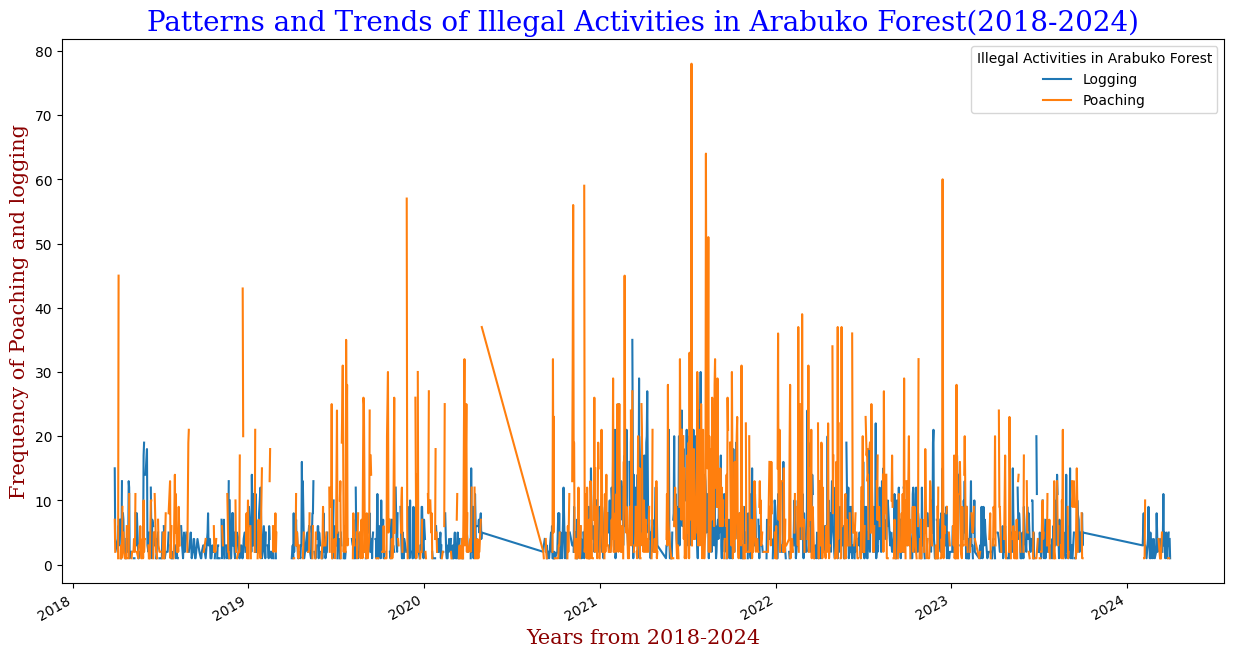

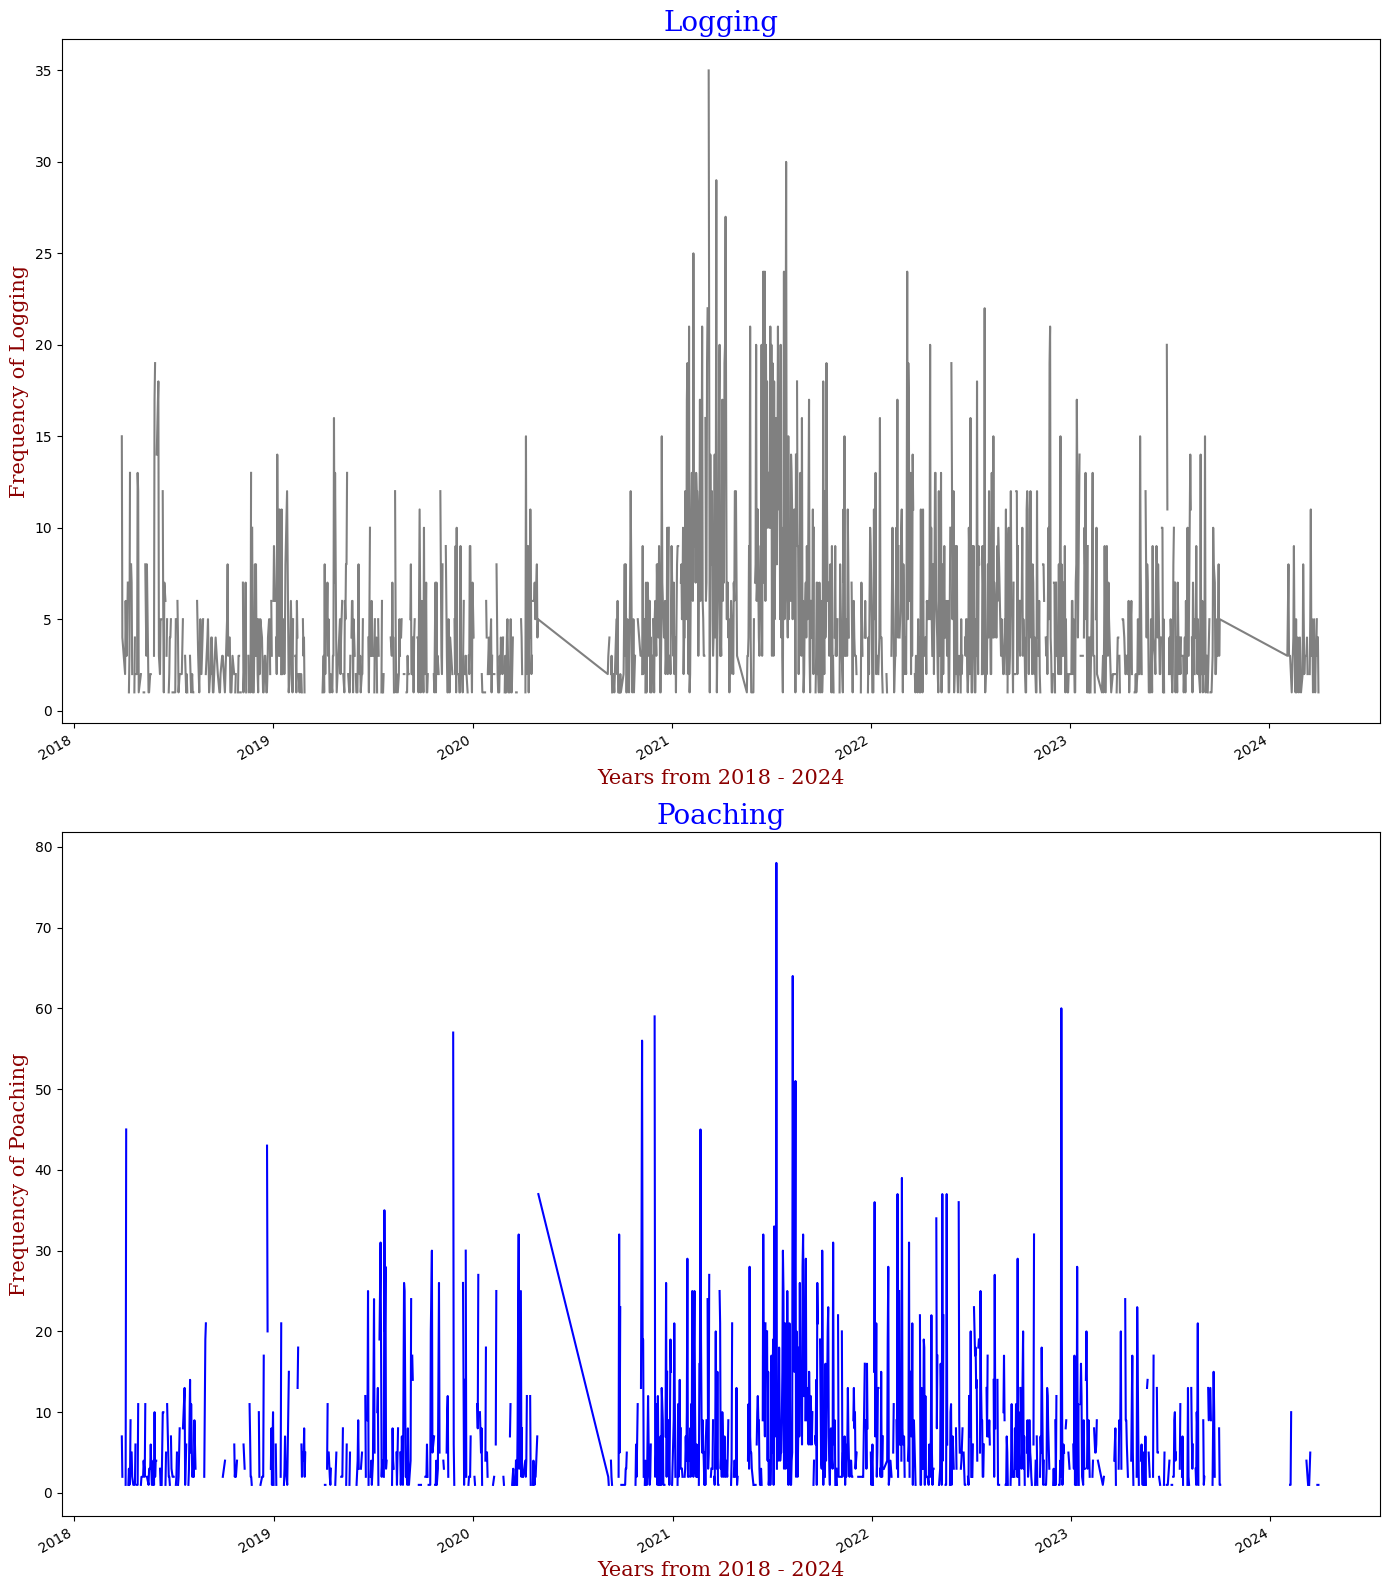

In [ ]:
#Time Series Analysis
#extract month fr
#feature engineer new dataframe 
time_data = illegal_df[["Waypoint Date","Illegal Activity"]]

#change datatype to datetime type 
time_data['Waypoint Date'] = pd.to_datetime(time_data['Waypoint Date'], format='%d-%b-%y')

#Grouping time_data using "Waypoint Date" and categorize the different illegal activities
#using unstuck to reshape the selected data, this categorize poaching and logging into separate columns
illegal_activities = time_data.groupby(["Waypoint Date","Illegal Activity"]).size().unstack()
# Forward fill missing values
time_data_filled = time_data.fillna(method='ffill')
#set waypoint date as index
time_data.set_index('Waypoint Date', inplace= True)

#set fontdict for x, y, and title labels
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':15}
#plot timeseries plot
illegal_activities["2018":].plot(figsize=(15,8));
plt.title("Patterns and Trends of Illegal Activities in Arabuko Forest(2018-2024)",fontdict= font1)
plt.xlabel("Years from 2018-2024", fontdict= font2)
plt.ylabel("Frequency of Poaching and logging",fontdict= font2)
plt.legend(title = "Illegal Activities in Arabuko Forest")
plt.show();

# Poaching and logging subplots
fig, axes = plt.subplots(nrows=len(illegal_activities.columns),
                         ncols=1, figsize=(14, 8*len(illegal_activities.columns)))

# Plot each activity on a separate subplot
color = ["grey","blue"]
for i, (columns ,color) in enumerate(zip(illegal_activities.columns, color)):
    illegal_activities = illegal_activities["2018":]
    illegal_activities[columns].plot(ax=axes[i], color = color)
    axes[i].set_title(columns,fontdict= font1)
    axes[i].set_xlabel('Years from 2018 - 2024',fontdict= font2)
    axes[i].set_ylabel(f"Frequency of {columns}",fontdict= font2)

plt.tight_layout()
plt.show()

#### Extract months from the Waypoint Date 
- group date in months
- visualize month against logging and poaching 

In [ ]:
#illegal_df['Month'] = illegal_df['Waypoint Date'].dt.month
#illegal_df['Month'] = illegal_df['Waypoint Date'].dt.month
Stella Ndegwa
9:34 PM
# Convert 'Waypoint Date' to datetime format
illegal_df['Waypoint Date'] = pd.to_datetime(illegal_df['Waypoint Date'])

# Extract month from 'Waypoint Date'
illegal_df['Month'] = illegal_df['Waypoint Date'].dt.month

# EDA on 'Illegal Activity' based on months
#activity_by_month = illegal_df.groupby(['Month', 'Illegal Activity']).size().unstack(fill_value=0)

# Plotting
#activity_by_month.plot(kind='bar', stacked=True, figsize=(12, 6), title='Illegal Activity by Month')


In [ ]:
illegal_df.columns

Index(['Waypoint Date', 'Waypoint Time', 'Eastings/Longitude',
       'Northings/Latitude', 'Illegal Activity', 'Observation Category 1',
       'Observation Category 2', 'Action Taken Camp', 'Action Taken Items',
       'Action Taken People', 'Arrested For', 'Home Town', 'Is Active',
       'Location Of Fire', 'Count', 'Status', 'Timber Tree Species',
       'Trap Size', 'Type of Cutting Tool', 'Type of Human Sign',
       'Type of Trap', 'Type of Weapon', 'Month', 'Year', 'Day_of_Week',
       'Lagged_Arrested_For_1', 'Lagged_Arrested_For_2',
       'Lagged_Arrested_For_3'],
      dtype='object')

In [ ]:
illegal_df.iloc[:2,:20]

,Waypoint Date,Waypoint Time,Eastings/Longitude,Northings/Latitude,Illegal Activity,Observation Category 1,Observation Category 2,Action Taken Camp,Action Taken Items,Action Taken People,Arrested For,Home Town,Is Active,Location Of Fire,Count,Status,Timber Tree Species,Trap Size,Type of Cutting Tool,Type of Human Sign
3,2021-07-10,11:09:13 AM,610882.8643,9636109.15,Logging,Timber,Cut branches,No Camp,Observed Only,No arrest,No Arrest,Other,Not applicable,Other,1,No Camp,Hard Wood,No Trap,No Cutting Tool,Absence of Human sign
4,2021-02-12,4:31:27 PM,595069.2919,9613245.00,Poaching,People,Not applicable,No Camp,Collected,No arrest,No Arrest,Other,No,Other,1,No Camp,Other,Small,No Cutting Tool,Absence of Human sign


In [ ]:
ille.corr()

Illegal Activity,Logging,Poaching
Illegal Activity,,
Logging,1.000000,0.830475
Poaching,0.830475,1.000000


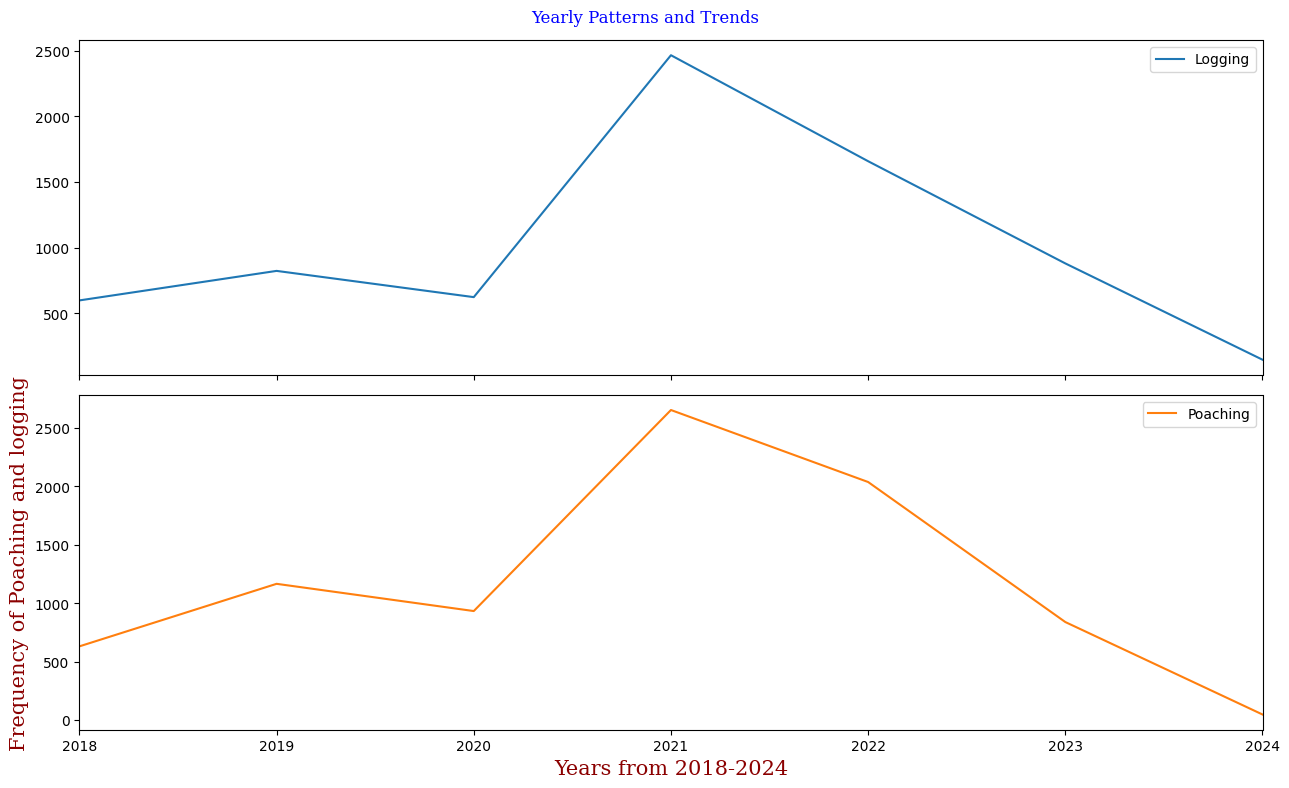

In [ ]:
#Yearly Trends and Patterns 
# Yearly grouping using groupby
annual_data = time_data.groupby(pd.Grouper(freq="A"))

# frequencies counts of "Waypoint Date" and "Illegal Activity"
yearly_freq = annual_data['Illegal Activity'].value_counts().unstack()

# Forward fill missing values
yearly_freq = yearly_freq.fillna(method='ffill')

# Plot yearly trends and patterns subplots
yearly_freq["2018":].plot(figsize=(13, 8), subplots=True, legend=True)

#labels and titles
plt.suptitle("Yearly Patterns and Trends",fontdict= font1)
plt.xlabel("Years from 2018-2024", fontdict= font2)
plt.ylabel("Frequency of Poaching and logging",fontdict= font2)

#plot
plt.tight_layout()
plt.show()




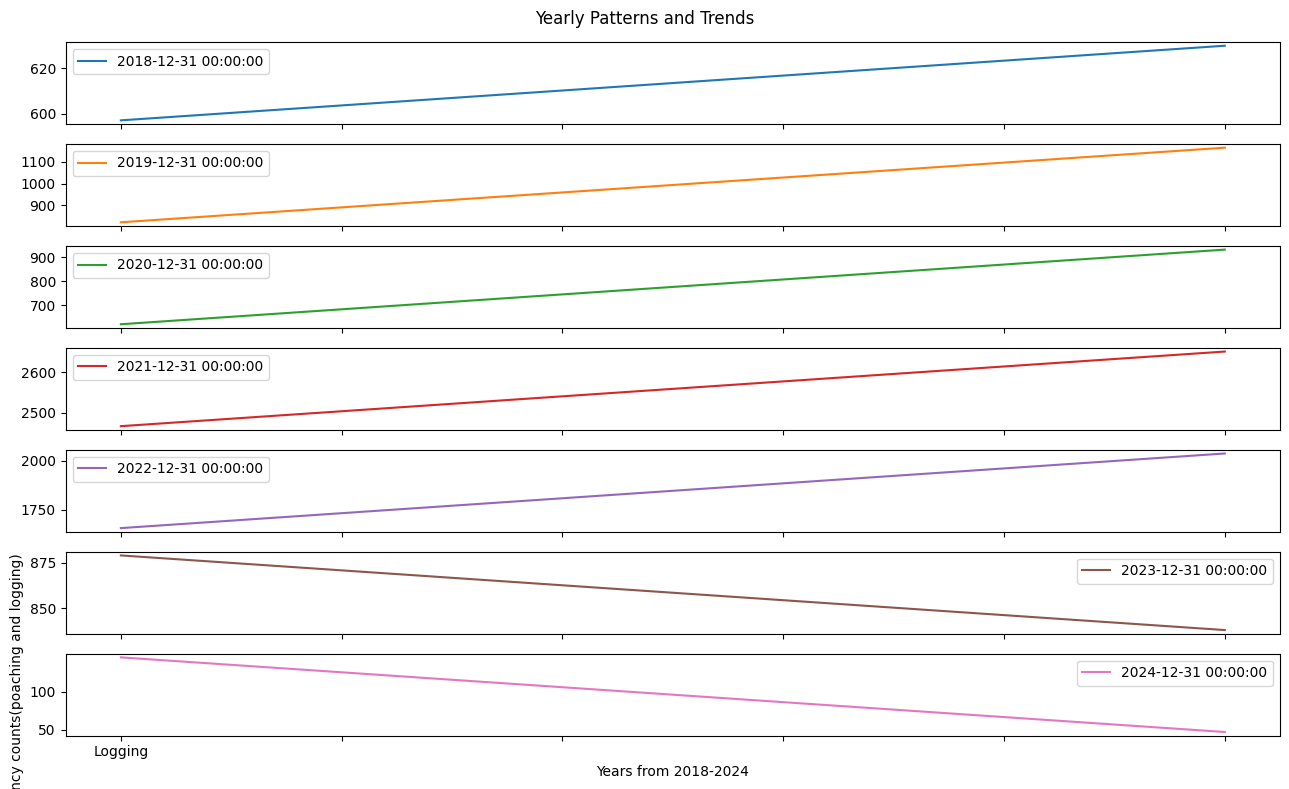

In [ ]:
#Trends and Patterns of the respective year

#Store values of poaching and logging as rows with respective years as columns
yearly_illegal_activities = yearly_freq["2018":].T

# Plot yearly trends and patterns subplots
yearly_illegal_activities.plot(figsize=(13, 8), subplots=True, legend=True)

# Labels and titles
plt.suptitle("Yearly Patterns and Trends")
plt.xlabel("Years from 2018-2024")
plt.ylabel("Frequency counts(poaching and logging)")

# layout modifications
plt.tight_layout()
plt.show()


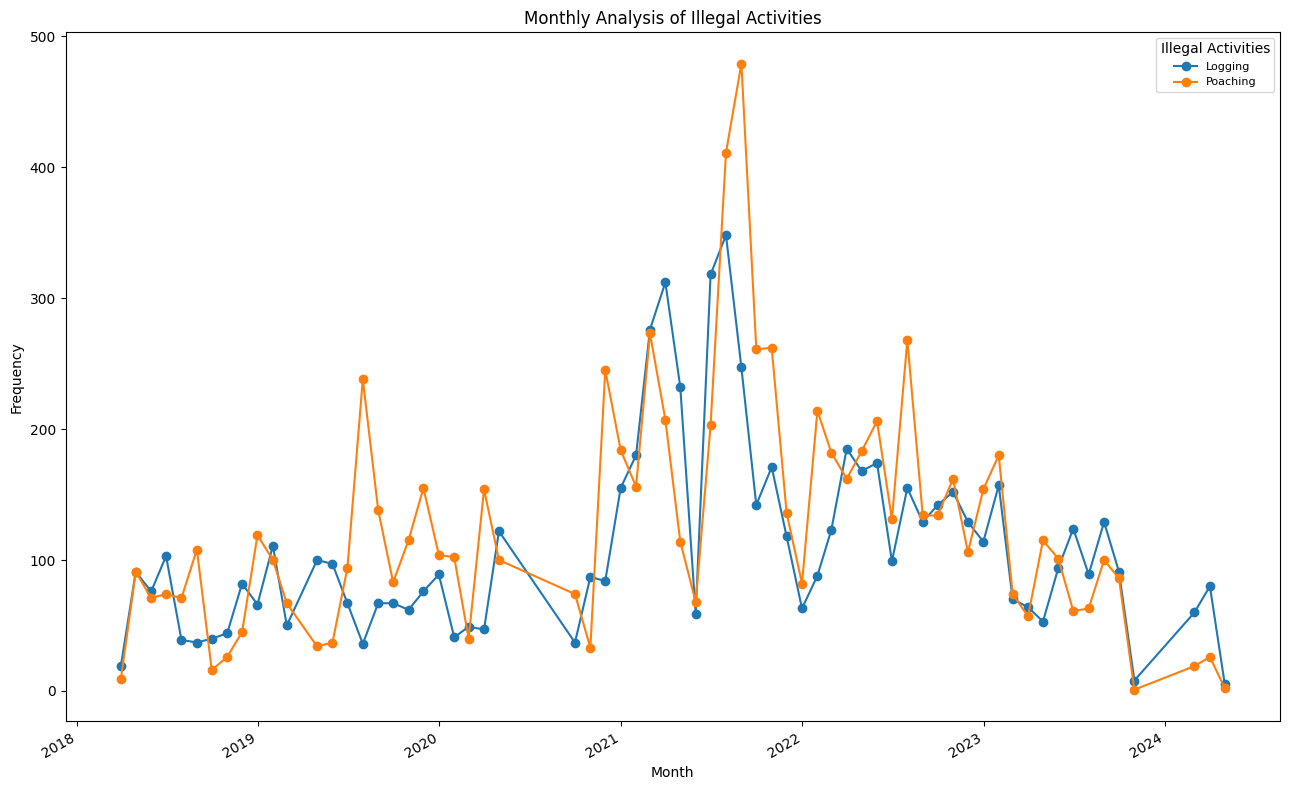

In [ ]:
#
# Group the data by month
monthly_data = time_data.groupby(pd.Grouper(freq="M"))

# Calculate the frequency counts of "Illegal Activity" for each month
monthly_freq = monthly_data['Illegal Activity'].value_counts().unstack()

# Forward fill missing values
monthly_freq = monthly_freq.fillna(method='ffill')

# Plot monthly analysis
monthly_freq["2018":].plot(figsize=(13, 8), marker='o', linestyle='-')

# Labels and titles
plt.title("Monthly Analysis of Illegal Activities")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.legend(title="Illegal Activities", fontsize=8)

# Show plot
plt.tight_layout()
plt.show()


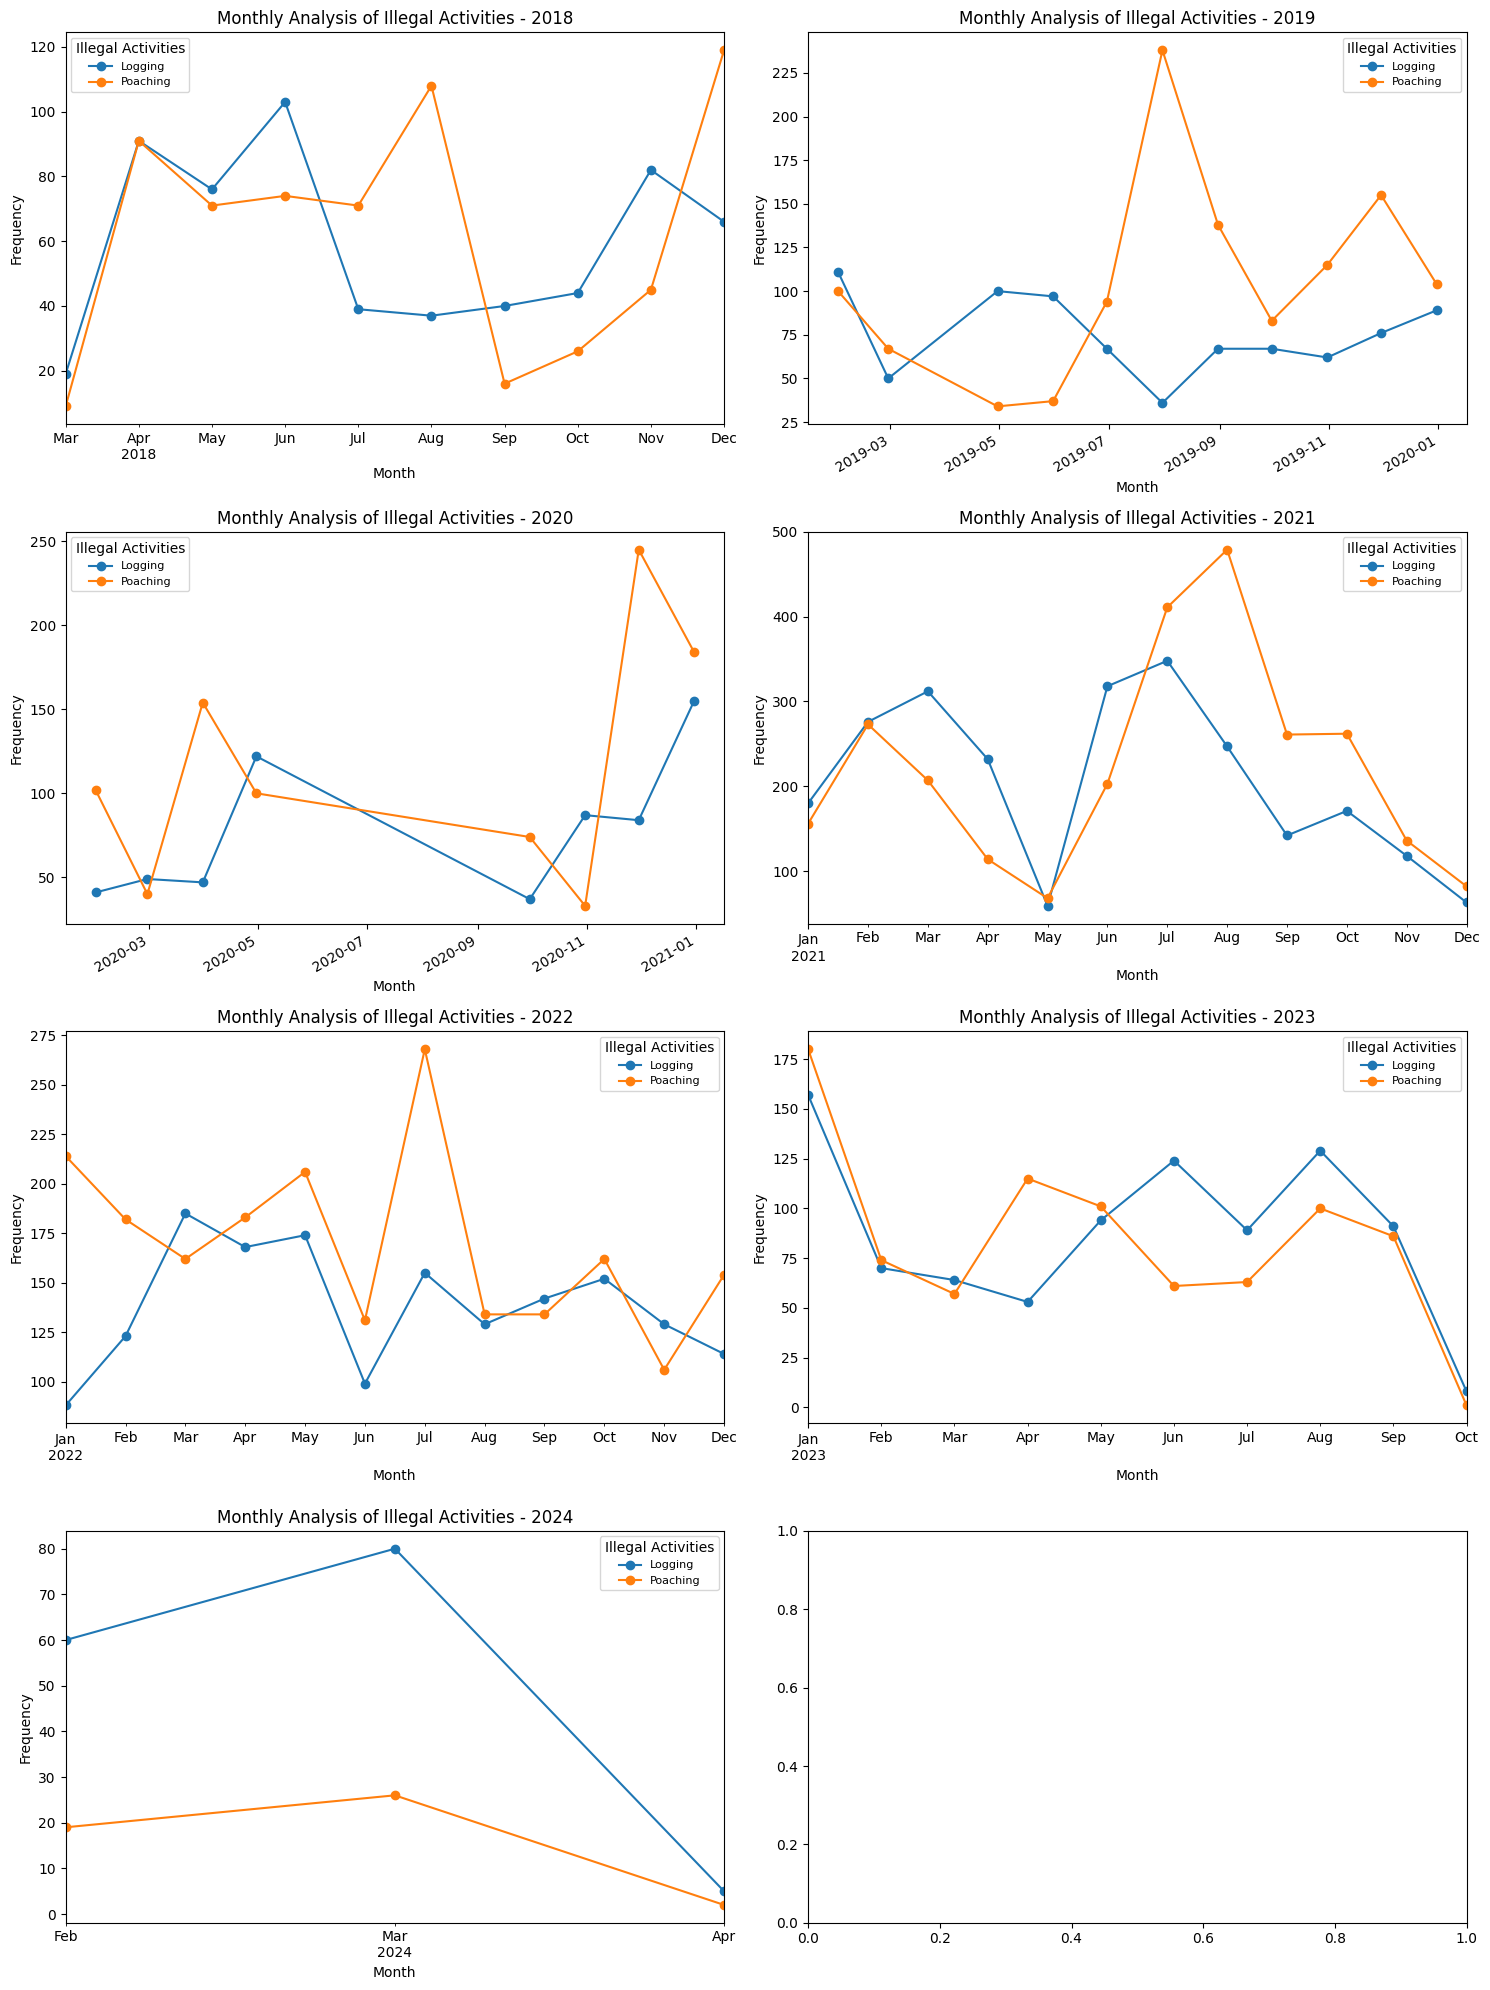

In [ ]:
import matplotlib.pyplot as plt

# Monthly Analysis
fig, axs = plt.subplots(4, 2, figsize=(15, 20))  # 4 rows, 2 columns

years = ["2018", "2019", "2020", "2021", "2022", "2023", "2024"]

for i, year in enumerate(years):
    row = i // 2
    col = i % 2
    ax = axs[row, col]

    # Plot for each year
    monthly_freq[year].plot(ax=ax, marker='o', linestyle='-')
    
    # Labels and titles
    ax.set_title(f"Monthly Analysis of Illegal Activities - {year}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Frequency")
    ax.legend(title="Illegal Activities", fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()

## 2. Time Series Analysis
1. Explore Temporal Trends
We'll plot the number of illegal activities (logging, poaching) over time 

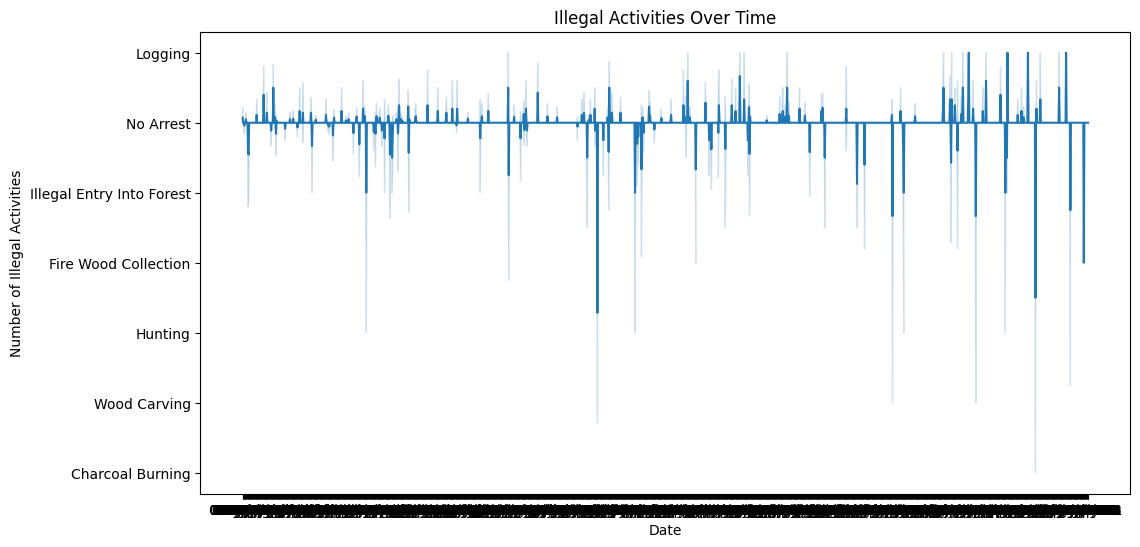

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the number of illegal activities over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Arrested For')
plt.title('Illegal Activities Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Illegal Activities')
plt.show()


In [ ]:
#illegal_df['Month'] = illegal_df['Waypoint Date'].dt.month

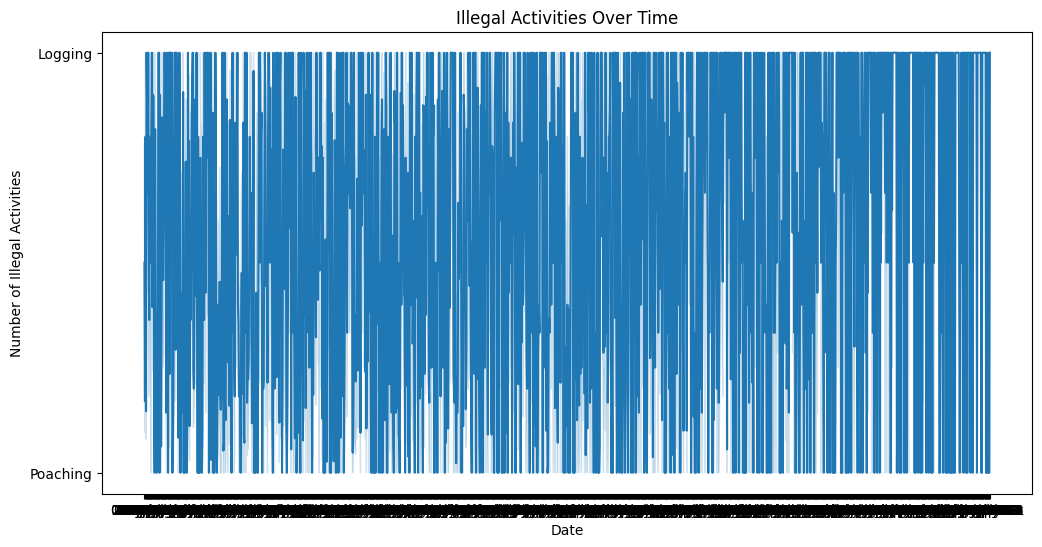

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the number of illegal activities over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Illegal Activity')
plt.title('Illegal Activities Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Illegal Activities')
plt.show()

In [ ]:
illegal_df.columns

Index(['Waypoint Date', 'Waypoint Time', 'Eastings/Longitude',
       'Northings/Latitude', 'Illegal Activity', 'Observation Category 1',
       'Observation Category 2', 'Action Taken Camp', 'Action Taken Items',
       'Action Taken People', 'Arrested For', 'Home Town', 'Is Active',
       'Location Of Fire', 'Count', 'Status', 'Timber Tree Species',
       'Trap Size', 'Type of Cutting Tool', 'Type of Human Sign',
       'Type of Trap', 'Type of Weapon'],
      dtype='object')

Key Findings:   
Trends Over Time: Trends in illegal activities over the years, potentially revealing if the situation is improving, worsening, or stable.

Long-Term Patterns: Identification of any long-term patterns, such as gradual increases or decreases in illegal activities.

Sudden Spikes or Drops: Any sudden spikes or drops in activity that might coincide with specific events or changes in the environment.

Implications:
Policy Decisions: Insights for policymakers on the effectiveness of existing policies and the need for new strategies.

Predictive Modeling: Data from the temporal analysis can feed into predictive models to forecast future illegal activities.

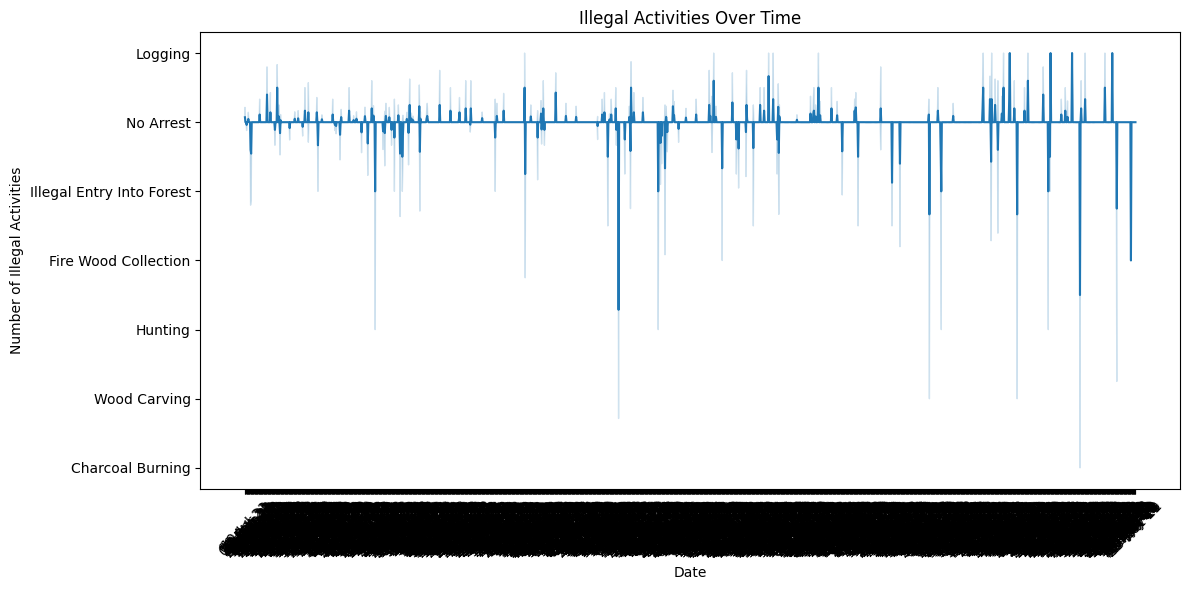

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the number of illegal activities over time with rotated x-axis labels
plt.figure(figsize=(12, 6))
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Arrested For')
plt.title('Illegal Activities Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Illegal Activities')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()



## 2. Seasonal Analysis
We'll identify key seasons or months with higher illegal activities and compare activity levels.

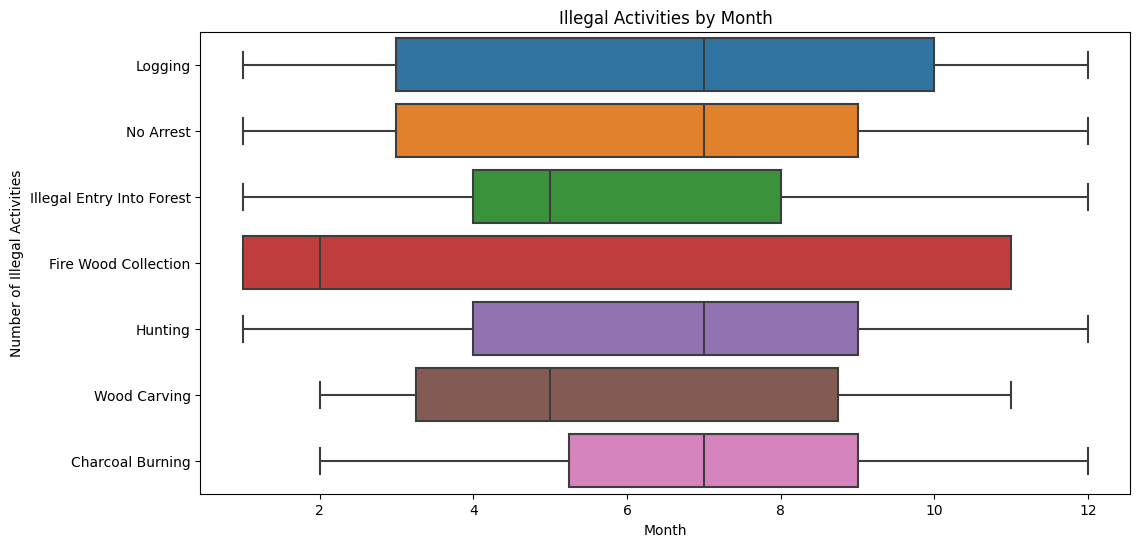

In [ ]:
# Convert "Waypoint Date" column to datetime type
illegal_df['Waypoint Date'] = pd.to_datetime(illegal_df['Waypoint Date'])

# Extracting month and year for analysis
illegal_df['Month'] = illegal_df['Waypoint Date'].dt.month
illegal_df['Year'] = illegal_df['Waypoint Date'].dt.year

# Plotting illegal activities by month
plt.figure(figsize=(12, 6))
sns.boxplot(data=illegal_df, x='Month', y='Arrested For')
plt.title('Illegal Activities by Month')
plt.xlabel('Month')
plt.ylabel('Number of Illegal Activities')
plt.show()


Key Findings:  
Seasonal Trends: The analysis likely revealed patterns in illegal activities that vary with the seasons. For example, there might be increased poaching during dry seasons when animals congregate near water sources.   
High and Low Seasons: Identified periods of the year when illegal activities are more prevalent (high season) and when they decrease (low season).   
Implications:  
Resource Allocation: Law enforcement can allocate more resources and patrols during high seasons to deter illegal activities.   
Conservation Efforts: Conservation organizations can plan interventions such as awareness campaigns or community engagement programs during low seasons to reduce illegal activities.  

## 3. spatial analysis

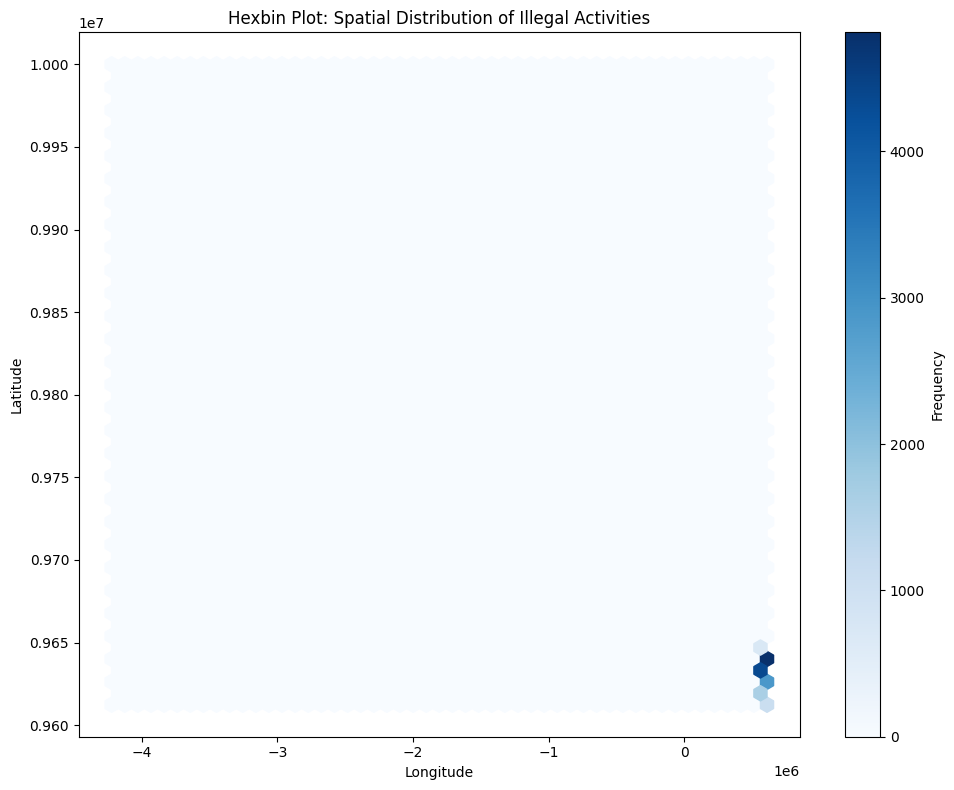

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Latitude' and 'Longitude' columns exist in illegal_df
plt.figure(figsize=(10, 8))
plt.hexbin(x=illegal_df["Eastings/Longitude"], y=illegal_df["Northings/Latitude"], gridsize=50, cmap='Blues')

# Add color bar for reference
plt.colorbar(label='Frequency')

plt.title('Hexbin Plot: Spatial Distribution of Illegal Activities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()


Key Findings:   
Hotspots: Identification of specific locations within the forest with high concentrations of illegal activities (hotspots).   
Clusters and Outliers: Spatial patterns showing clusters of illegal activities as well as outliers—locations with unexpectedly high or low activity.   
Border Areas: Analysis of activities near the forest boundary, which might indicate interactions with neighboring communities or external influences.   
Implications:   
Targeted Enforcement: Law enforcement can focus patrols and surveillance efforts on identified hotspots and clusters to prevent further illegal activities.  
Conservation Planning: Insights for conservationists to prioritize areas for protection and restoration based on the spatial distribution of threats.  
Community Engagement: Understanding illegal activities near the forest boundary can guide community engagement strategies to address root causes and reduce pressures on the forest.   

## Feature Engineering 

In [ ]:

import pandas as pd

# Assuming 'Waypoint Date' is your timestamp column
illegal_df['Waypoint Date'] = pd.to_datetime(illegal_df['Waypoint Date'])

# Extract features: Day of the week, Month, Year
illegal_df['Day_of_Week'] = illegal_df['Waypoint Date'].dt.dayofweek
illegal_df['Month'] = illegal_df['Waypoint Date'].dt.month
illegal_df['Year'] = illegal_df['Waypoint Date'].dt.year

# Lag features: Create lagged versions of the target variable
# We'll create 3 lagged features (you can adjust this as needed)
for i in range(1, 4):
    illegal_df[f'Lagged_Arrested_For_{i}'] = illegal_df['Arrested For'].shift(i)

# Drop rows with NaN (due to shifting for lagged features)
illegal_df.dropna(inplace=True)

# Print the updated DataFrame with new features
illegal_df.head()

,Waypoint Date,Waypoint Time,Eastings/Longitude,Northings/Latitude,Illegal Activity,Observation Category 1,Observation Category 2,Action Taken Camp,Action Taken Items,Action Taken People,...,Type of Cutting Tool,Type of Human Sign,Type of Trap,Type of Weapon,Month,Year,Day_of_Week,Lagged_Arrested_For_1,Lagged_Arrested_For_2,Lagged_Arrested_For_3
3,2021-07-10,11:09:13 AM,610882.8643,9636109.150,Logging,Timber,Cut branches,No Camp,Observed Only,No arrest,...,No Cutting Tool,Absence of Human sign,No trap,No weapon,7,2021,5,No Arrest,No Arrest,Logging
4,2021-02-12,4:31:27 PM,595069.2919,9613245.000,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,No Cutting Tool,Absence of Human sign,Snare,No weapon,2,2021,4,No Arrest,No Arrest,No Arrest
5,2021-08-09,1:15:02 PM,593225.8838,9639809.145,Poaching,People,Not applicable,No Camp,Collected,No arrest,...,No Cutting Tool,Absence of Human sign,Snare,No weapon,8,2021,0,No Arrest,No Arrest,No Arrest
6,2019-06-27,10:29:16 AM,607434.9180,9637604.844,Logging,Timber,Building Poles,No Camp,Observed Only,No arrest,...,No Cutting Tool,Absence of Human sign,No trap,No weapon,6,2019,3,No Arrest,No Arrest,No Arrest
7,2021-04-09,12:38:26 PM,590886.5009,9620416.127,Logging,Timber,Cut Stems,No Camp,Observed Only,No arrest,...,No Cutting Tool,Absence of Human sign,No trap,No weapon,4,2021,4,No Arrest,No Arrest,No Arrest


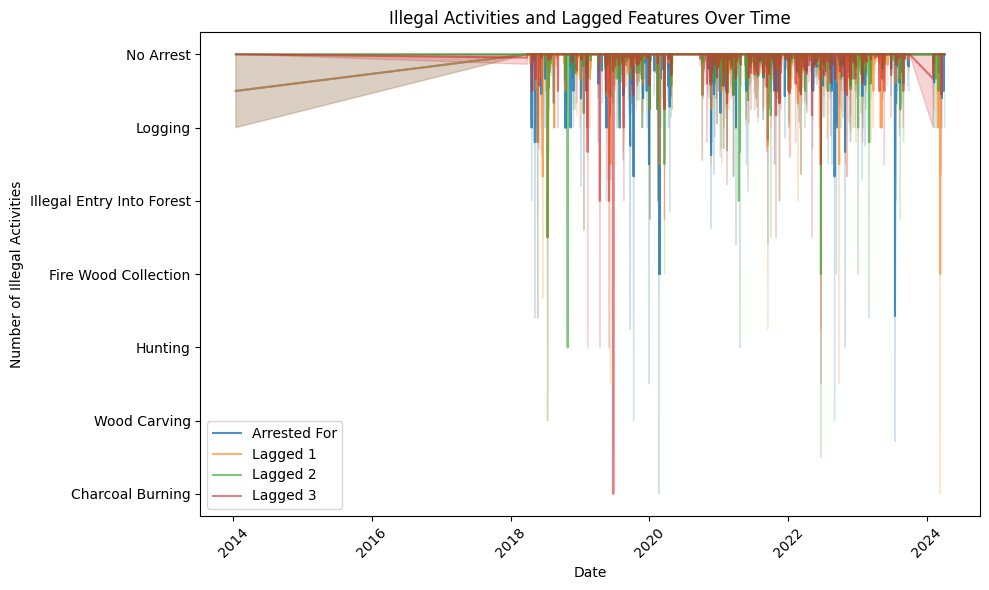

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the lagged features vs. Arrested For
plt.figure(figsize=(10, 6))

# Plot the target variable
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Arrested For', label='Arrested For', alpha=0.8)

# Plot the lagged features
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Lagged_Arrested_For_1', label='Lagged 1', alpha=0.6)
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Lagged_Arrested_For_2', label='Lagged 2', alpha=0.6)
sns.lineplot(data=illegal_df, x='Waypoint Date', y='Lagged_Arrested_For_3', label='Lagged 3', alpha=0.6)

plt.title('Illegal Activities and Lagged Features Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Illegal Activities')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot we generated compares the target variable 'Arrested For' (representing the number of illegal activities) with its lagged versions over time. Here's an explanation of the outcome:   

Target Variable ('Arrested For'): The solid line labeled 'Arrested For' represents the actual number of illegal activities (the target variable) observed at each timestamp along the x-axis. This line shows the actual trend of illegal activities in the dataset.     
Lagged Features ('Lagged 1', 'Lagged 2', 'Lagged 3'):     
'Lagged 1' represents the number of illegal activities at the previous timestamp.       
'Lagged 2' represents the number of illegal activities two timestamps ago.     
'Lagged 3' represents the number of illegal activities three timestamps ago.   
Observations:     
Correlation with Lagged Features:     
If the lagged features are positively correlated with the target variable, we should see similar trends between them.     
For example, if 'Lagged 1' is positively correlated with 'Arrested For', we would expect to see similar movements in their lines.    
A positive correlation means when 'Lagged 1' increases, 'Arrested For' also tends to increase in the next timestamp.    
Lead/Lag Relationships:    
The lagged features give us insight into how past values of the target variable influence its current value.    
A significant lag indicates that past values of 'Arrested For' have a strong impact on the current number of illegal activities.     
Patterns and Trends:     
Any patterns or trends visible in the 'Arrested For' line should also somewhat reflect in the lagged features.    
If there's a recurring pattern (like seasonal peaks or declines), we might see this reflected in the lagged features with a slight delay.    
Interpretation:    
Lagged Features vs. Target Variable:     
The closer the lagged lines follow the 'Arrested For' line, the stronger the correlation between past and present illegal activities.    
If a lagged feature consistently lags behind 'Arrested For', it suggests a delayed impact of past activities on current arrests.    
Prediction and Forecasting:    
Understanding these lagged relationships is crucial for time series forecasting.    
We can use this information to build predictive models that forecast future illegal activities based on past values.    
Modeling and Predictive Analysis:    
By including these lagged features in machine learning models, we can potentially improve the accuracy of our predictions.    
Models like ARIMA (AutoRegressive Integrated Moving Average) or LSTM (Long Short-Term Memory) in neural networks can utilize these lagged features for forecasting.      

### Exploratory Data Visualization

#### Univariate Analysis
Let's explore the distribution of individual variables.

StopIteration: 

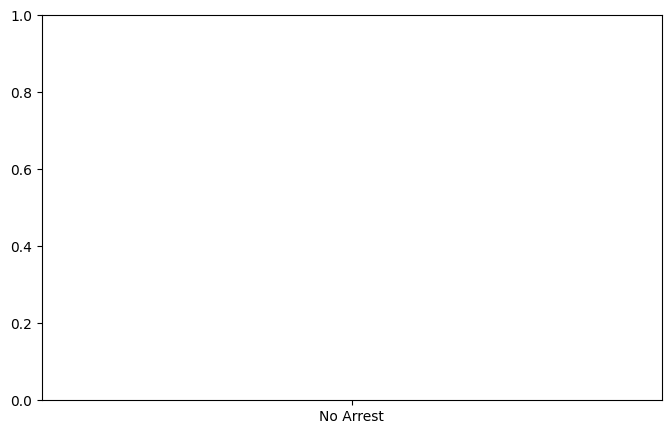

In [ ]:
# Histogram of 'Arrested For' (illegal activities)
plt.figure(figsize=(8, 5))
sns.histplot(data=illegal_df, x='Arrested For', bins=20, kde=True)
plt.title('Distribution of Illegal Activities')
plt.xlabel('Number of Illegal Activities')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Larger figure size and rotated x-axis labels
plt.figure(figsize=(12, 6))
sns.histplot(data=illegal_df, x='Arrested For', bins=20, kde=True)
plt.title('Distribution of Illegal Activities')
plt.xlabel('Number of Illegal Activities')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

In [ ]:
# Filter out rows with "No Arrest" for a cleaner histogram
filtered_df = illegal_df[illegal_df['Arrested For'] != 'No Arrest']

# Larger figure size and rotated x-axis labels
plt.figure(figsize=(12, 6))
sns.histplot(data=filtered_df, x='Arrested For', bins=20, kde=True)
plt.title('Distribution of Illegal Activities (Excluding "No Arrest")')
plt.xlabel('Number of Illegal Activities')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## bivariate analysis

In [ ]:
# Scatter plot with regression line
plt.figure(figsize=(8, 5))
sns.regplot(data=illegal_df, x='Lagged_Arrested_For', y='Arrested For', scatter_kws={'alpha':0.5})
plt.title('Scatter Plot: Illegal Activities vs Lagged Activities')
plt.xlabel('Lagged Illegal Activities')
plt.ylabel('Illegal Activities')
plt.show()


# Modelling: Time Series 

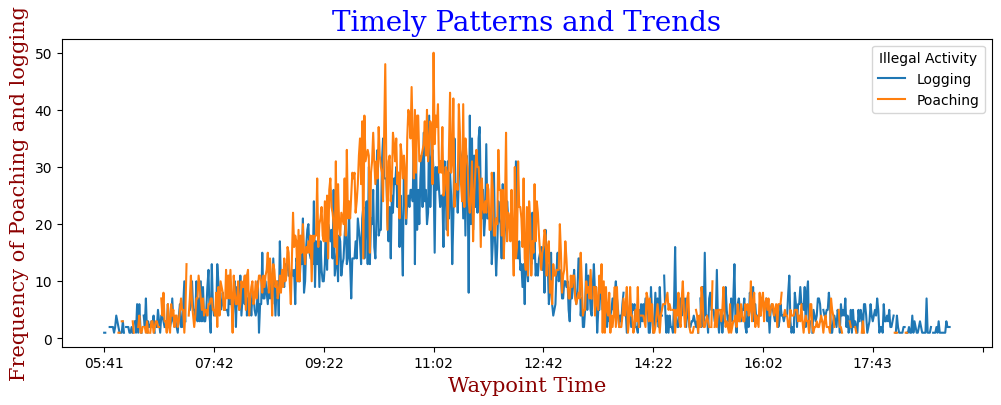

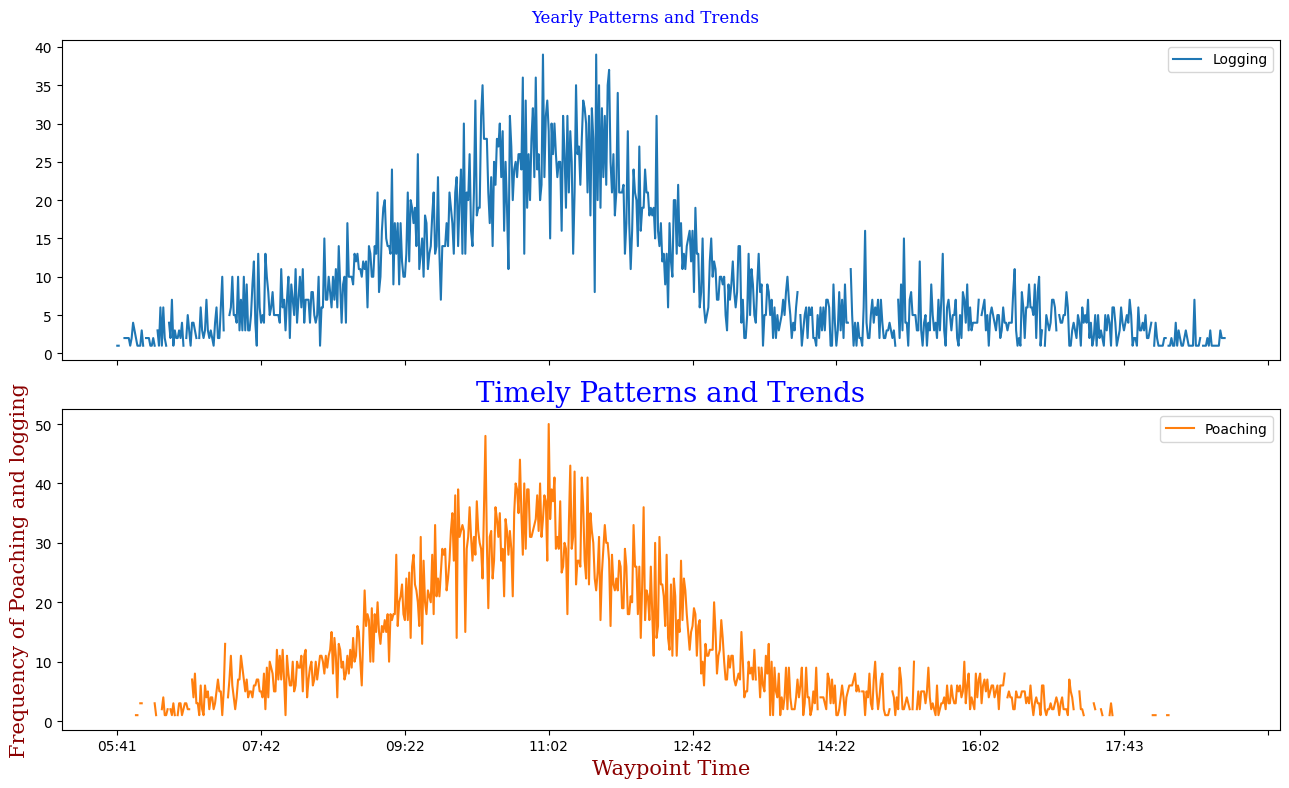

In [ ]:
#feature engineer
time_data = illegal_df[["Waypoint Time", "Illegal Activity"]]


#change data type to timestamp
# Convert 'Waypoint Time' to datetime format
time_data["Waypoint Time"] = pd.to_datetime(time_data['Waypoint Time'], format='%I:%M:%S %p')

#set waypoint time as index
time_data.set_index("Waypoint Time", inplace= True)

#group the occurrences in their respective date and time

time_data = time_data.groupby([time_data.index.strftime('%H:%M'), "Illegal Activity"]).size().unstack()


#plot data
time_data.plot(figsize=(12,4), subplots=False, legend=True)
plt.title("Timely Patterns and Trends",fontdict= font1)
plt.xlabel("Waypoint Time", fontdict= font2)
plt.ylabel("Frequency of Poaching and logging",fontdict= font2)


#Plot subplots
time_data.plot(figsize=(13, 8), subplots=True, legend=True);
plt.title("Timely Patterns and Trends",fontdict= font1)
plt.suptitle("Yearly Patterns and Trends",fontdict= font1)
plt.xlabel("Waypoint Time", fontdict= font2)
plt.ylabel("Frequency of Poaching and logging",fontdict= font2)

#plot
plt.tight_layout()
plt.show()

In [ ]:
time_data.head(10)

The graph shows non-stationary. The mean, variance, and co-variance are subject to time. There is need to remove trends before modelling. Then use the residue for time series modeling. The best method to use in this case is decomposition. Because,both the mean and variance change with time. 

In [ ]:
#check for missing values 
print("The missing values in the data:", time_data.isna().sum())



In [ ]:
time_data[["Logging","Poaching"]].fillna(method = "ffill")
time_data.isna().sum()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Fill missing values if any (optional)
time_data_filled = time_data.fillna(value = 0)#specify column

# Perform seasonal decomposition
decomposition = seasonal_decompose(time_data, period=24)  # Assuming a daily periodicity

# Access the seasonal component
seasonal_component = decomposition.seasonal

# Remove seasonality by subtracting the seasonal component from the original data
time_data_deseasonalized = time_data - seasonal_component

# Now, 'time_data_deseasonalized' contains your data with seasonality removed

# Optionally, you can visualize the components
import matplotlib.pyplot as plt

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))

plt.subplot(411)
time_data.plot(ax=plt.gca(), label='Original', color='blue')
plt.legend(loc='best')
plt.title('Original Data')

plt.subplot(412)
trend.plot(ax=plt.gca(), label='Trend', color='blue')
plt.legend(loc='best')
plt.title('Trend Component')

plt.subplot(413)
seasonal.plot(ax=plt.gca(), label='Seasonality', color='blue')
plt.legend(loc='best')
plt.title('Seasonal Component')

plt.subplot(414)
residual.plot(ax=plt.gca(), label='Residuals', color='blue')
plt.legend(loc='best')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


In [ ]:
# Import and apply seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(ts))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(ts), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming time_data is your DataFrame with missing values
# Fill missing values using backward fill method
time_data_filled = time_data['Poaching'].fillna(method='bfill')

# Perform seasonal decomposition
decomposition = seasonal_decompose(time_data_filled, period=24)  # Assuming a daily periodicity

# Access the seasonal component
seasonal_component = decomposition.seasonal
